In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from metrics import Pearson
from collections import OrderedDict
from keras.utils import to_categorical
from keras.models import load_model
from utils import prepare_data
from dataloaders import GeneDataLoader




In [12]:
def one_hot_emb(data: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'A': 0,
        'C': 1,
        'G': 2,
        'T': 3
    }
    one_hot_encode_lam = lambda seq: to_categorical([mapping[x] for x in seq])
    return data.apply(one_hot_encode_lam)

def exclude_zero_gradients(gradient):
    value = np.sum(gradient)
    return value is None or value == 0.0

In [13]:
"""
    Integrated Gradients
"""
from motif_search import motif_utilities

model_name = "CNN_RNN_no_str"

model = load_model(f'trained_models/{model_name}.h5',compile=False)

struct = False

m6A = False

In [14]:
train_data, valid_data, test_data = prepare_data()

max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()

dataloader = GeneDataLoader(train_data, shuffle=False, padding_length=max_seq_len, struct=False, m6A=False)

compartments = ["ERM", "KDEL", "LMA", "MITO", "NES", "NIK", "NLS", "NUCP", "OMM"]

data_split_in_compartments = {
    "ERM": [],
    "KDEL": [],
    "LMA": [],
    "MITO": [],
    "NES": [],
    "NIK": [],
    "NLS": [],
    "NUCP": [],
    "OMM": [],
}

# Add the compartments in their respective cluster
for x_batch, y_batch in dataloader:
    for i in range(len(y_batch)):
        index = y_batch[i].argmax(axis=0)
        data_split_in_compartments[compartments[index]].append(x_batch[0][i])

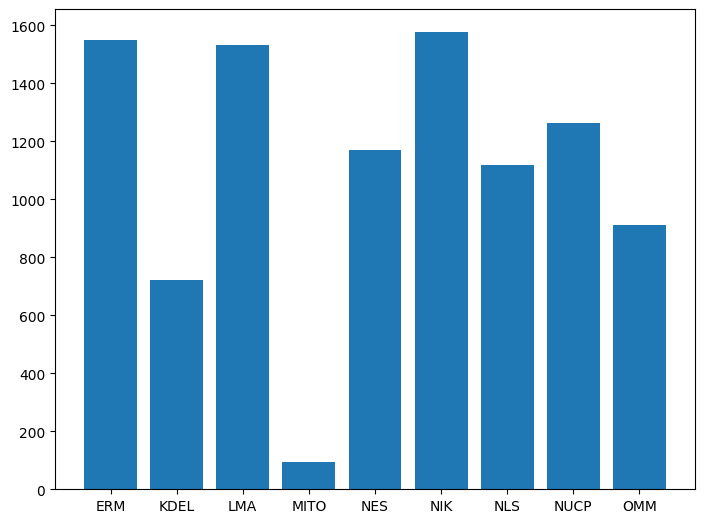

In [15]:
# Plot distribution of most likely compartment

compartment_distribution = [len(data_split_in_compartments[compartment]) for compartment in data_split_in_compartments.keys()]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(compartments,compartment_distribution)
plt.show()

In [16]:
# Downsample compartments because of computational considerents
number_of_samples = 100

for compartment in data_split_in_compartments:
    if len(data_split_in_compartments[compartment]) > 100:
        data_split_in_compartments[compartment] = random.sample(data_split_in_compartments[compartment], number_of_samples)
    print(f"{compartment} has len: {len(data_split_in_compartments[compartment])}")

ERM has len: 100
KDEL has len: 100
LMA has len: 100
MITO has len: 95
NES has len: 100
NIK has len: 100
NLS has len: 100
NUCP has len: 100
OMM has len: 100


In [ ]:
"""
    Compute and Plot Gradients
"""

selected_compartments = ["ERM", "KDEL", "LMA", "MITO", "NES", "NIK", "NLS", "NUCP", "OMM"]

number_of_nucleotides = 100

start_of_gradient = max_seq_len - number_of_nucleotides

for compartment in data_split_in_compartments:
    if compartment in selected_compartments:
        print(f"Computing gradient of - {compartment}")
        compartment_data = data_split_in_compartments[compartment]
        gradient_of_compartment = motif_utilities.get_gradients(model, compartment_data)

        if not os.path.isdir(f"motif_search/integrated_gradients/{compartment}"):
            os.mkdir(f"motif_search/integrated_gradients/{compartment}")

        for i in range(len(compartment_data)):
            if not exclude_zero_gradients(gradient_of_compartment[i][start_of_gradient:]):
                # motif_utilities.plot_weights(compartment_data[i][start_index:], subticks_frequency = 10)
                motif_utilities.plot_weights(gradient_of_compartment[i][start_of_gradient:], subticks_frequency=10)
                plt.savefig(f'motif_search/integrated_gradients/{compartment}/{compartment}_seq{i}.png')